<a href="https://colab.research.google.com/github/abdalazizrashid/Auger-Electron-Spectroscopy/blob/master/Copy_of_XPS_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob
import os.path as osp
import re
plt.rcParams['axes.grid'] = True

### Reading asc file

In [0]:
class AesSpec:
    def __init__(self, filename):
    
        #assert filename.endswith('.asc')
        with open(filename, mode='r') as f:
            self.spec_range = f.readline()
            self.meta0 = f.readline()
            self.surv = f.readline()
            self.something = int(f.readline())
            self.ev_min = float(f.readline())
            self.ev_step = float(f.readline())
            self.n_points = int(f.readline())
            self.data = np.zeros(self.n_points)
            for i in range(self.n_points):
                self.data[i] = float(f.readline())
        idx = pd.Index(data=np.linspace(
                                    self.ev_min,
                                    self.ev_min + self.n_points*self.ev_step,
                                    self.n_points),
                       name='eV')
        self.ts = pd.Series(self.data,
                            name=os.path.split(filename)[-1],
                            index=idx)

    @staticmethod
    def all_specs():
        return glob.glob('asc/*-aes.asc')

In [0]:
root_path = "/home/master/Notebook/AES_standard/*"
dataset = []
elements = []
lenght = []
for file in glob.glob(root_path):
    try:
        filename = osp.splitext(osp.split(file)[-1])[0]
        specs = AesSpec(file).ts
        y = specs.iloc[:].to_numpy()
        #x = specs.index.to_numpy()
        elements.append(filename)
        dataset.append(y)
        lenght.append(len(y))
    except:
        print("Error Reading file!")
dataset, elements_array = np.array(dataset), np.array(elements)


elements = []
for i in elements_array:
  d = re.search(r"([a-zA-Z]*)([0-9])*", i)
  elements.append(d.group(1))


711 3191


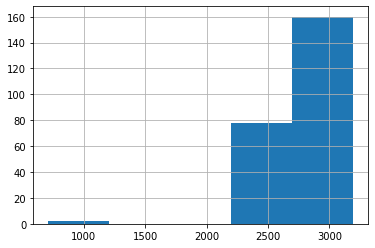

In [265]:
plt.hist(lenght, bins=5)
print(min(lenght), max(lenght))

In [0]:
def smoothdiffS7D7(cnts):
    ''' Create smooth differentiated column from counts using S7D7 PHI algorithm (Multipak tables 
    A-5 and A-1; passing np array (not pandas series)''' 
    numpts=len(cnts)
    endpts=[0,len(cnts)-1] # legacy way of defining endpoints and internal breaks (although those no longer present)
    smooth=[0]*numpts # empty list of correct length for smoothed data
    smoothdiff=[0]*numpts # 7 pt diff of above smoothed data
    # smoothing of endpoints according to Multipak algorithm appendix table A-5    
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list            
        if diff==0:
            if i==numpts-1: #last point
                smooth[i]=(2*cnts[i]+2*cnts[i-1]+1)/4 # additional special case for last point
            else: # first point
                smooth[i]=(2*cnts[i]+2*cnts[i+1]+1)/4 # all others at exact breaks can use value and adj higher value
        elif abs(diff)==1:  # works for +1 or -1 from nearest break
            smooth[i]=(1*cnts[i-1]+2*cnts[i]+1*cnts[i+1]+1)/4
        elif abs(diff)==2:
            smooth[i]=(-3*cnts[i-2]+12*cnts[i-1]+17*cnts[i]+12*cnts[i+1]+-3*cnts[i+2]+1)/35
        else:
            smooth[i]=(-2*cnts[i-3]+3*cnts[i-2]+6*cnts[i-1]+7*cnts[i]+6*cnts[i+1]+3*cnts[i+2]-2*cnts[i+3]+1)/21

    # Same structure to perform differentiation on smoothed datalist above
    for i in range(0,numpts): # special cases for endpoints (within 3 of an evbreak)
        diff=i-min(endpts, key=lambda x:abs(x-i)) # distance from closest evbreak index # in list
        if abs(diff)<=2:
            smoothdiff[i]=0  # just zero out endpoints (old code moved to python software dev xls cell)
        else:
            smoothdiff[i]=(-3*smooth[i-3]-2*smooth[i-2]-1*smooth[i-1]+1*smooth[i+1]+2*smooth[i+2]+3*smooth[i+3]+1)/28
    smoothdiff=np.asarray(smoothdiff)
    return smoothdiff

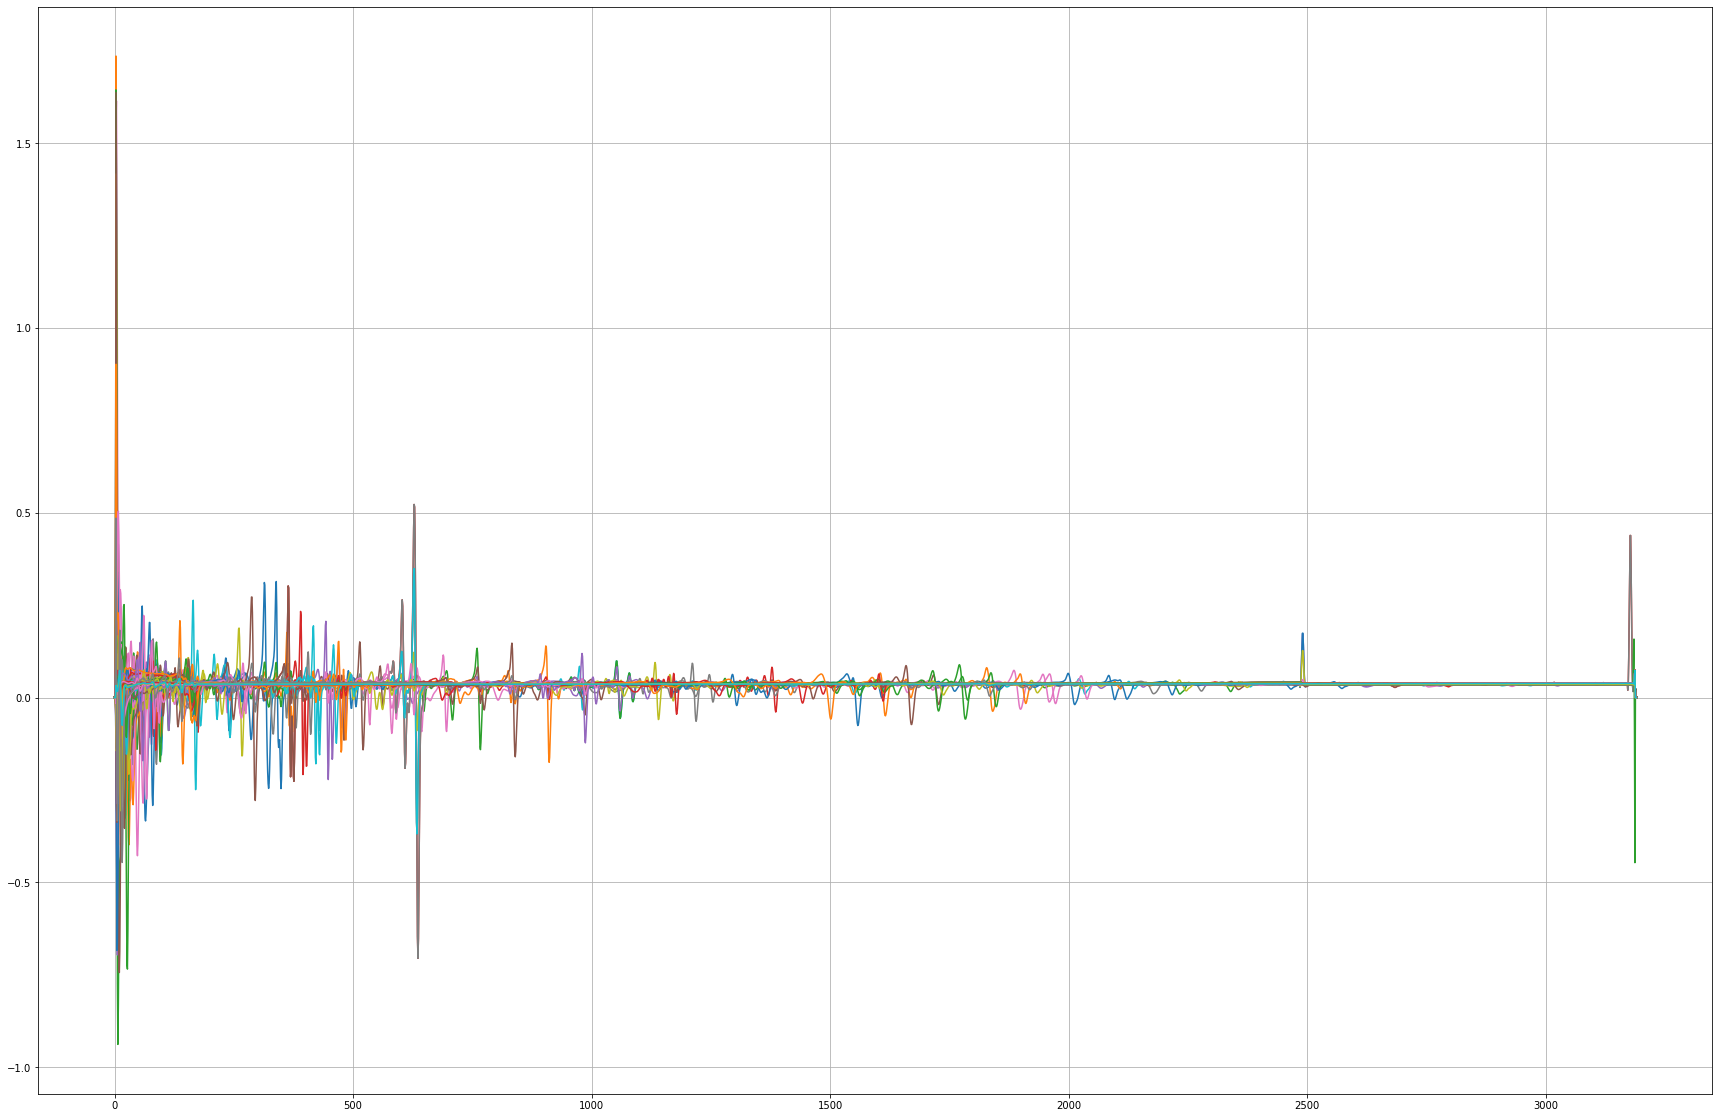

In [6]:
plt.figure(figsize=(30,20))
# Normalize to mean of 0 and standard deviation of 1
def norm(x): return (x-np.mean(x))/np.std(x)

# Normalize to a range between 0, 1
def norm2(x): return (x-np.min(x))/(np.max(x) - np.min(x))

# Padding to respect to the maximum lenght in the dataset
def pad(x):
    shape = ((max(lenght)-len(x)))
    p = np.full(shape, max(x))
    p = np.insert(p, 0, x)
    return p
X = []
Y = []
for i in range(len(dataset)):
    tmp = smoothdiffS7D7(pad(norm(dataset[i])))
    #tmp = pad(norm(dataset[i]))

    plt.plot(tmp)
    Y.append(tmp)
    X.append(np.arange(0, len(tmp)))
#plt.xscale('log')  
#plt.plot(norm(dataset[100]), alpha=0.5, color='r', marker='.')
plt.show()
Y = np.array(Y)
x = np.array(X)


In [0]:
# fig, ax = plt.subplots(len(dataset)//4, 4, figsize = (50, 100))
# plt.grid(True)
# for i in range(len(dataset)):
#     ax.flat[i].plot(dataset[i])
#     ax.flat[i].set_title(elements[i])
#     ax.flat[i].get_xaxis().set_ticks([])
# #fig.savefig("AudioWaveform", dpi=900)     

In [8]:
plt.figure(figsize=(30,10))

def mixture(input_array, num_of_samples=3, parameter=1000):
    mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
    _y = np.zeros((3191))
    for i in range(num_of_samples):
        print()
        _y += np.sqrt(np.power(np.random.permutation(mix[i] * input_array[i], ), 2))
    return _y


plt.plot(mixture(Y, num_of_samples=, parameter= 1000),'r')
plt.plot(Y[0], '.')
plt.plot(Y[1], '-')
plt.plot(Y[2], '-')
plt.show()


#   mix = np.random.dirichlet(np.ones(num_of_samples)/parameter)
#     _y = np.zeros((3191))
#     for i in range(num_of_samples):
#         print()
#         _y += mix[i] * input_array[i]
#     return _y

SyntaxError: ignored

In [0]:
smth = np.zeros((Y.shape[0], ))
smth1 = np.random.dirichlet(np.ones(3))


In [0]:
plt.plot(smth2)

In [0]:
plt.figure(figsize=(20, 15))
plt.plot(Y[1])
plt.plot(Y[100])
plt.plot(mixture(Y, 3)[0], color='r')
plt.show()

In [222]:
Y.shape

(240, 3191)

In [0]:
import torch
import re
from torch.utils.data import Dataset, DataLoader
cuda = torch.device('cuda:0')
class Data(Dataset):
   

    def __init__(self, data, name, mixtures=False, n_comps=4, alpha=1.):
        self.mixtures = mixtures
        self.n_comps = n_comps
        self.alpha = alpha
        self.data = data
        self.name = pd.get_dummies(name).to_numpy()
        assert len(name) == len(data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.mixtures:
            components = np.random.permutation(len(self.data))[:self.n_comps]
            gamma = np.ones(self.n_comps) * self.alpha
            small_weights = np.random.dirichlet(gamma)
            weights = np.zeros(len(self.data))
            weights[components] = small_weights
            target = (self.name * weights[:, None]).sum(0)
            y = (self.data * weights[:, None]).sum(0)
            return torch.from_numpy(y).view(1, 3191), target
        else:      
            if torch.is_tensor(idx):
                idx = idx.tolist()
            y = self.data[idx]
            return torch.tensor((y)).view(1, 3191), torch.tensor(self.name[idx]).float()
    
    

In [249]:
np.random.random_integers(1, 50)

/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 50 + 1) instead
  """Entry point for launching an IPython kernel.


49

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.24022919 0.         0.         0.         0.
 0.40269335 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.33850284 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.01857463 0.         0.        ]


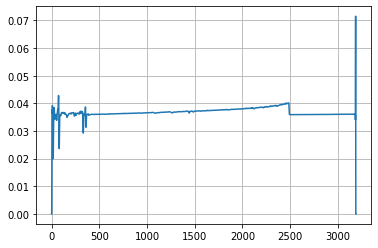

In [261]:
test = Data(Y, elements, mixtures=True, n_comps=4)
plt.plot(test[0][0].reshape(-1, 1))
#test1 = Data(Y, elements, mixtures=False)[0][0]
#plt.plot(test1.reshape(-1, 1), c='r')

print(test[0][1])

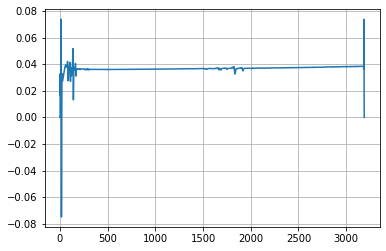

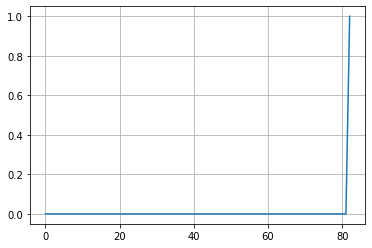

In [8]:
plt.plot(Data(Y, elements)[239][0].numpy().reshape(-1, 1))
plt.show()
plt.plot(Data(Y, elements)[239][1].numpy())


In [0]:
bs = 1
trainloader = torch.utils.data.DataLoader(Data(Y, elements), batch_size=bs,
                                         shuffle=True, num_workers=6, pin_memory=False)

In [10]:
import pandas as pd
import wandb
import torch


#90dd838e588a5bce5c551a082a1dfdb39dff7487

wandb.init(project="test")


# s = pd.Series(np.arange(1, 118))
# y = pd.get_dummies(s).to_numpy()
# _y = np.arange(0, 118)
# X = torch.tensor(Y.reshape(1, 3191, -1)).float()
# y = torch.tensor(_y.reshape(1, 118)).float()
# Y = np.random.randint(0, 9, 10).reshape(1, 1, -1)

class Simple1DCNN(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNN, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=11, stride=1)
        self.conv2 = torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=21, stride=1, padding=5)
        self.conv3= torch.nn.Conv1d(in_channels=1, out_channels=128, kernel_size=41, stride=1, padding=15)
        self.conv4= torch.nn.Conv1d(in_channels=384, out_channels=1024, kernel_size=5, stride=1)### in_channels=384
        self.avg5= torch.nn.AdaptiveAvgPool1d(1)
        self.sigmoid= torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        def relu(x): return x.clamp(0.) - 0.5
        

        self.flatten= torch.nn.Flatten()
        
        # dense layer has 4*512 input dim
        # Contamination
        self.dropout= torch.nn.Dropout(p=0.2)
        self.co_dense1= torch.nn.Linear(in_features=1024, out_features=512)
        self.co_dense2= torch.nn.Linear(in_features=512, out_features=1)
        
        # Quantification
        
        self.qu_dense1= torch.nn.Linear(in_features=1025, out_features=2048)
        self.qu_dense2= torch.nn.Linear(in_features=2048, out_features=84)
        self.norm= torch.nn.LayerNorm((84),elementwise_affine=False)
        
    def forward(self, x):
        f_1_1 = self.relu(self.conv1(x))
        f_1_2 = self.relu(self.conv2(x))
        f_1_3 = self.relu(self.conv3(x))


        t = torch.cat((f_1_1, f_1_2, f_1_3), dim=1)


        f_2 = self.conv4(t)
        f_2 = self.avg5(f_2)
        f_2 = self.flatten(f_2)

        f_3 = self.dropout(f_2)
        f_3 = self.co_dense1(f_3)
        f_3 = self.relu(f_3)
        f_3 = self.co_dense2(f_3)
        

        
        #f_4 = self.dropout(torch.cat((f_3, f_2), dim=1))
        f_4 = torch.cat((f_3, f_2), dim=1)
        f_4 = self.qu_dense1(f_4)
        f_4 = self.relu(f_4)
        f_4 = self.qu_dense2(f_4)
        #f_4 = self.sigmoid(f_4)
       # f_4 = self.norm(f_4)

        
        


        return f_4[...,:-1], f_4[...,-1]
    
    



wandb: Wandb version 0.8.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


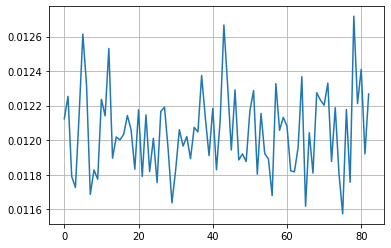

In [11]:
x = next(iter(Data(Y, elements)))[0].view(1, 1, -1).float()

fr = Simple1DCNN().forward(x)[0].detach()#.detach().numpy()
soft = torch.nn.Softmax(dim=-1)
new = soft(fr).numpy()
plt.plot(new.reshape(-1, 1))

In [12]:
cuda = torch.device('cuda:0')

model = Simple1DCNN().to(cuda)
def cross_entropy_one_hot(input, _001CuI13, target):
    labels = target.max(dim=1)[1]
    return torch.nn.CrossEntropyLoss()(input, labels)
wandb.watch(model)

In [0]:
import math
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1.

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)

    return lr_lambda

In [0]:
import torch.distributions.relaxed_categorical

In [0]:
class DickLoss(torch.nn.Module):
  def forward(self, input, temp, target):
    # target = torch.distributions.utils.clamp_probs(target)
    # temp = torch.full_like(temp, 1e-1)
    # dist = torch.distributions.relaxed_categorical.ExpRelaxedCategorical(temp.unsqueeze(-1), logits=input)
    # return -dist.log_prob(target).mean()
    target = target.argmax(-1)
    print(target.shape)
    return torch.nn.CrossEntropyLoss()(
        input, target
    )

class Myloss(torch.nn.Module):
  def forward(self, input, _, target):
    loss = (torch.pow(input, 2) * torch.pow((input - target), 2)).sum()
    return loss 

In [0]:
dirloss = DickLoss()#Myloss()#cross_entropy_one_hot#DickLoss()

In [17]:
p = torch.rand(3, 240)
p /= p.sum(-1, keepdim=True)
dirloss(p, torch.ones(3), p)

torch.Size([3])


tensor(5.4764)

In [0]:
# from tensorboardX import SummaryWriter
            

# writer = SummaryWriter()

loss_fn = dirloss #cross_entropy_one_hot
learning_rate = 3e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
step_size = 4*len(trainloader)
clr = cyclical_lr(step_size)
#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, [clr])

import tqdm

In [0]:
def accuracy(out, yb): 
  print("---------------",torch.argmax(out, dim=-1))
  print("---------------",torch.argmax(yb, dim=-1))


  return (torch.argmax(out, dim=-1) == torch.argmax(yb, dim=-1)).float().mean()

In [0]:
#wandb.config.update(args)
def update_log(log):
  wandb.log(log)

def train(epoch=100000, trainloader=trainloader):
  cuda = torch.device('cuda:0')

  log = {"epoch": [], "loss": [], "acc": [], "forward": []}
  pre_acc = 0
  with tqdm.tqdm(range(epoch)) as _epochs:
    for epoch in _epochs:
        lr = 0
        for i , data in enumerate(trainloader, 0):
            # Forward pass: compute predicted y by passing x to the model.
            x, y = data; 
            x = x.to(cuda)
            y = y.to(cuda)
            
          
            y_pred, t_pred = model(x.float())
            
            
            # Compute and print loss.
            loss = loss_fn(y_pred, t_pred, y)

            log["acc"] = acc = accuracy(y_pred, y).item() 

            log["loss"] = loss.item()
            print(acc)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 7)

            optimizer.step()
      
            #_epochs.set_description(f"epoch={epoch} acc={acc} loss={loss:.4f}")
        log["epoch"] = epoch
        log["forward"] = y_pred
       # update_log(log)
        if round(acc, 1) > round(pre_acc, 1):
          checkpoint = {'model': Simple1DCNN(),
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()}

          torch.save(checkpoint, str(round(acc, 1)) +'.pth')
          pre_acc = acc
          print("saved check point")
        




In [31]:
train()

  0%|          | 0/100000 [00:00<?, ?it/s]

torch.Size([1])
--------------- tensor([48], device='cuda:0')
--------------- tensor([48], device='cuda:0')
1.0
torch.Size([1])
--------------- tensor([50], device='cuda:0')
--------------- tensor([45], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([18], device='cuda:0')
--------------- tensor([61], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([55], device='cuda:0')
--------------- tensor([24], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([43], device='cuda:0')
--------------- tensor([38], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([75], device='cuda:0')
--------------- tensor([0], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([6], device='cuda:0')
--------------- tensor([28], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([20], device='cuda:0')
--------------- tensor([20], device='cuda:0')
1.0
torch.Size([1])
--------------- tensor([57], device='cuda:0')
--------------- tensor([57], device='cuda:0'

/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Simple1DCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type AdaptiveAvgPool1d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctne

saved check point
torch.Size([1])
--------------- tensor([27], device='cuda:0')
--------------- tensor([3], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([14], device='cuda:0')
--------------- tensor([14], device='cuda:0')
1.0
torch.Size([1])
--------------- tensor([62], device='cuda:0')
--------------- tensor([73], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([21], device='cuda:0')
--------------- tensor([64], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([48], device='cuda:0')
--------------- tensor([69], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([26], device='cuda:0')
--------------- tensor([68], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([71], device='cuda:0')
--------------- tensor([40], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([31], device='cuda:0')
--------------- tensor([31], device='cuda:0')
1.0
torch.Size([1])
--------------- tensor([75], device='cuda:0')
--------------- tensor([7

  0%|          | 1/100000 [00:05<157:07:27,  5.66s/it]

torch.Size([1])
--------------- tensor([49], device='cuda:0')
--------------- tensor([49], device='cuda:0')
1.0
torch.Size([1])
--------------- tensor([34], device='cuda:0')
--------------- tensor([39], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([40], device='cuda:0')
--------------- tensor([71], device='cuda:0')
0.0
torch.Size([1])
--------------- tensor([77], device='cuda:0')
--------------- tensor([12], device='cuda:0')
0.0


KeyboardInterrupt: ignored

In [0]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    #for parameter in model.parameters():
     #   parameter.requires_grad = False

    model#.eval()
    return model

model = load_checkpoint('1.0.pth').to(cuda)

ag
--------------- tensor([76], device='cuda:0')
--------------- tensor(0)
tensor(0., device='cuda:0')
[[76 24 82 30 22 23 25 26 27 28 29 31 20 32 33 34 35 36 37 38 21 19 40 18
   1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 39 41 81 42 63 64 65
  66 67 68 69 70 71 72 73 74 75 77 78 79 80 62 61 60 50 43 44 45 46 47 48
  49 51 59 52 53 54 55 56 57 58  0]]
[1.0, 2.79e-43, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


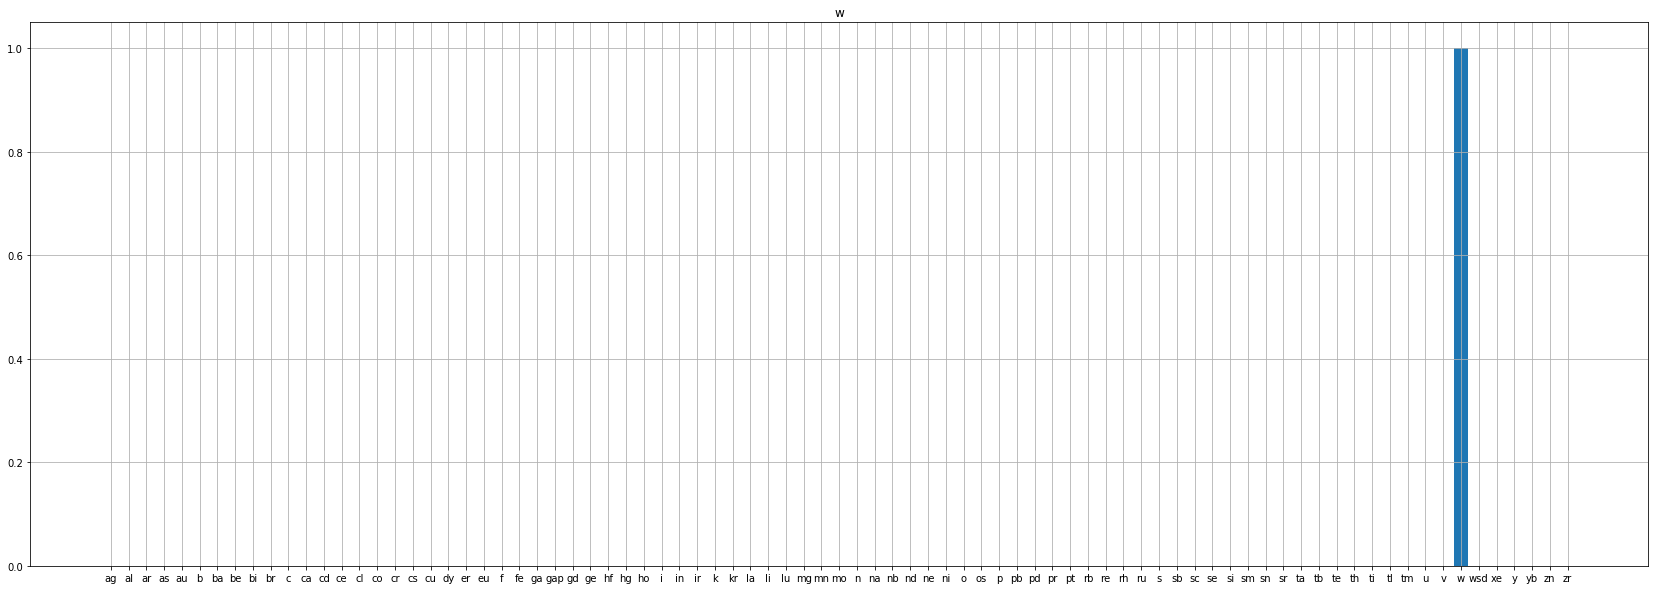

1.0
['w' 'ga' 'zr' 'ho' 'f' 'fe' 'gap' 'gd' 'ge' 'hf' 'hg' 'i' 'er' 'in' 'ir'
 'k' 'kr' 'la' 'li' 'lu' 'eu' 'dy' 'mn' 'cu' 'al' 'ar' 'as' 'au' 'b' 'ba'
 'be' 'bi' 'br' 'c' 'ca' 'cd' 'ce' 'cl' 'co' 'cr' 'cs' 'mg' 'mo' 'zn' 'n'
 'si' 'sm' 'sn' 'sr' 'ta' 'tb' 'te' 'th' 'ti' 'tl' 'tm' 'u' 'v' 'wsd' 'xe'
 'y' 'yb' 'se' 'sc' 'sb' 'p' 'na' 'nb' 'nd' 'ne' 'ni' 'o' 'os' 'pb' 's'
 'pd' 'pr' 'pt' 'rb' 're' 'rh' 'ru' 'ag'] flipped


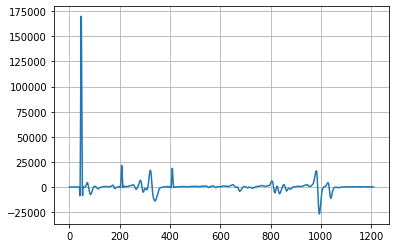

In [221]:
import json
plt.figure(figsize=(29, 10)) 
cuda = torch.device('cuda:0')

data = json.load(open("/home/master/Notebook/AES_DATABASE/json/001ZnOe27.json"))
infre = torch.tensor(smoothdiffS7D7((norm(data["Specs"]))), device=cuda).float().view(1, 1, -1)

uniq_elements = list(sorted(set(elements)))
idx = 1
#nfre = Data(Y, elements)[idx][0].view(1, 1, -1).float().to(cuda)
target = Data(Y, elements)[idx][1]
print(Data(Y, elements)[idx][2])
results = model.forward(infre)[0]
print(accuracy(results, target))
sx = torch.nn.Softmax(dim=-1)
results = sx(results).cpu().detach().numpy()
plt.bar(uniq_elements, results[0][:])
plt.title(uniq_elements[np.argmax(results)])
print(np.flip(np.argsort(results)))
print(sorted(results[0], reverse=True))
plt.show()
plt.plot(smoothdiffS7D7(data["Specs"]))
print(results.sum())



#########################
exs = []
for item in np.argsort(results)[0]:
  exs.append((sorted(set(elements))[item]))
print(np.flip(exs), "flipped")


In [175]:
print(results[0].shape)
len(set(elements))

(83,)


83

In [174]:
sorted(set(elements))[81]

'zn'

In [0]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)

In [0]:
dump_tensors()

/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Series.data is deprecated and will be removed in a future version
/home/master/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Float64Index.data is deprecated and will be removed in a future version
/usr/local/anaconda/envs/fastai/lib/python3.7/site-packages/torch/distributed/distributed_c10d.py:101: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn("torch.distributed.reduce_op is deprecated, please use "
wandb: WARNING import wandb.keras called before import keras or import tensorflow.keras.  This can lead to a version mismatch, W&B now assumes tensorflow.keras


Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 128 × 3181
Tensor: GPU pinned 240 × 384 × 3181
Parameter: GPU pinned 128 × 1 × 11
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 1 × 21
Parameter: GPU pinned 128
Parameter: GPU pinned 128 × 1 × 41
Parameter: GPU pinned 128
Parameter: GPU pinned 1024 × 384 × 5
Parameter: GPU pinned 1024
Parameter: GPU pinned 512 × 1024
Parameter: GPU pinned 512
Parameter: GPU pinned 1 × 512
Parameter: GPU pinned 1
Parameter: GPU pinned 2048 × 1025
Parameter: GPU pinned 2048
Parameter: GPU pinned 84 × 2048
Parameter: GPU pinned 84
Tensor: GPU pinned 240 × 1 × 3191
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240 × 83
Tensor: GPU pinned 240
Tensor: GPU pinned 
Total size: 593454950


In [0]:
torch.cuda.empty_cache()

In [0]:
model = None

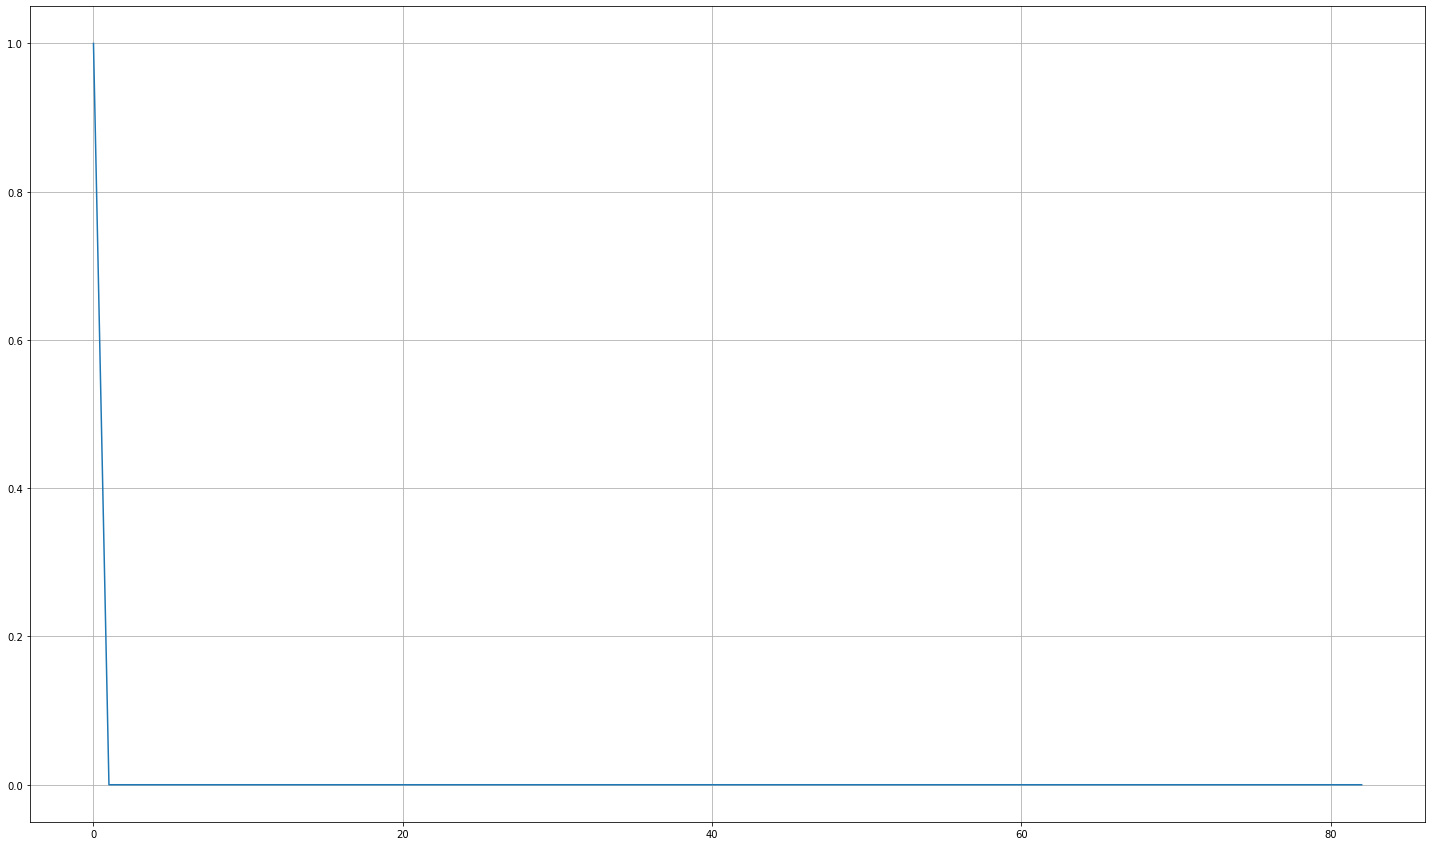

In [37]:
plt.figure(figsize=(25, 15))
for i in Data(Y, elements):
  plt.plot(i[1].numpy().reshape(-1, 1))
  #plt.plot(i[0].numpy().reshape(-1, 1))
  break

In [43]:
i[1].argmax()

tensor(0)